In [1]:
using CSV, DataFrames, FASTX, StatsPlots, Serialization, StatsBase

In [2]:
bases = Dict('A'=>1, 'C'=>2, 'G'=>3, 'T'=>4, 'U'=>4)
aas = Dict('A'=>1, 'C'=>2, 'D'=>3, 'E'=>4, 'F'=>5, 'G'=>6, 'H'=>7, 'I'=>8, 'K'=>9, 'L'=>10, 'M'=>11, 'N'=>12,
     'P'=>13, 'Q'=>14, 'R'=>15, 'S'=>16, 'T'=>17, 'V'=>18, 'W'=>19, 'Y'=>20)

aligned_motifs = ["P1","L1","S1","P2","L2","S2","SS", "P1i","L1i","S1i","P2i","L2i","S2i","SSi"]

14-element Vector{String}:
 "P1"
 "L1"
 "S1"
 "P2"
 "L2"
 "S2"
 "SS"
 "P1i"
 "L1i"
 "S1i"
 "P2i"
 "L2i"
 "S2i"
 "SSi"

In [3]:
species = Dict("phylloglossum" => "Phylloglossum drummondii", "phlegmariurus" => "Phlegmariurus squarrosus", "huperzia" => "Huperzia serrata")
genes = ["cob", "nad1", "nad5", "rpl2"]

function read_motifs(species::String, gene::String)
    infile = joinpath(species * "_KP", join([species, "dywkp", gene, "motifs"], "_") * ".txt")
    if !isfile(infile); return nothing; end
    motifs = CSV.File(infile, header=["protein", "start", "end", "score", "sequence", "second", "fifth", "last", "motif"]) |> DataFrame
    #motifs.motif = replace.(motifs.motif, "i" => "")
    motifs.second = getindex.(motifs.second, 1)
    motifs.fifth = getindex.(motifs.fifth, 1)
    motifs.last = getindex.(motifs.last, 1)
    motifs.protein = first.(split.(motifs.protein, "."))
    select(motifs, Not(:sequence))
    filter!(x->x.motif ∈ aligned_motifs, motifs)
end

function read_target(species::String, gene::String)
    targetfile = joinpath(species * "_KP", join([species, "dywkp", gene, "target"], "_") * ".fasta")
    if !isfile(targetfile); return nothing; end
    rna = FASTA.Reader(open(targetfile)) do infile
        rec = first(infile)
        reverse(sequence(rec))[5:end]
    end
end

struct PPR
    name::String
    motifs::Vector{String}
    seconds::Vector{Int}
    fifths::Vector{Int}
    lasts::Vector{Int}
end


In [4]:
pprs = PPR[]

for spec in keys(species), gene in genes
    motifs = read_motifs(spec, gene)
    isnothing(motifs) && continue
    for ppr in unique(motifs.protein)
        ppr_motifs = motifs[motifs.protein .== ppr, :]
        filter!(x->x.motif ∈ aligned_motifs, ppr_motifs)
        sort!(ppr_motifs, :start, rev=true)
        push!(pprs, PPR(spec * "_" * gene, ppr_motifs.motif, map(x->aas[x], ppr_motifs.second), map(x->aas[x], ppr_motifs.fifth), map(x->aas[x], ppr_motifs.last)))
    end
end

pprs

10-element Vector{PPR}:
 PPR("huperzia_cob", ["S2", "L2", "P2", "S1", "L1", "P1", "S1", "L1", "P1", "S1", "L1", "P1"], [4, 18, 18, 10, 8, 18, 18, 8, 18, 18, 20, 5], [16, 8, 6, 17, 1, 12, 12, 1, 12, 12, 18, 16], [3, 6, 3, 6, 3, 3, 3, 3, 3, 3, 3, 12])
 PPR("huperzia_nad1", ["S2", "L2", "P2", "S1", "L1", "P1", "S1", "L1", "P1", "S1", "L1", "P1"], [4, 18, 18, 8, 8, 18, 18, 18, 18, 20, 20, 5], [17, 10, 6, 12, 1, 16, 12, 18, 16, 17, 18, 16], [12, 16, 3, 3, 4, 3, 3, 12, 12, 3, 3, 3])
 PPR("huperzia_nad5", ["S2", "L2", "P2", "S1", "L1", "P1", "S1", "L1", "P1", "S1", "L1", "P1"], [4, 18, 18, 10, 18, 18, 18, 18, 18, 5, 20, 20], [17, 10, 6, 17, 1, 16, 12, 2, 12, 12, 18, 12], [12, 16, 3, 12, 3, 3, 3, 3, 3, 3, 7, 12])
 PPR("huperzia_rpl2", ["S2", "L2", "P2", "S1", "L1", "P1", "S1", "L1", "P1", "S1", "L1", "P1"], [4, 18, 18, 10, 8, 18, 18, 16, 18, 5, 20, 20], [12, 8, 6, 12, 1, 16, 16, 10, 6, 12, 18, 15], [3, 16, 3, 3, 12, 3, 3, 3, 12, 3, 3, 12])
 PPR("phylloglossum_cob", ["S2", "L2", "P2", "S1", "L1

In [5]:
sites = Dict{String, String}()
for spec in keys(species), gene in genes
    target = read_target(spec, gene)
    isnothing(target) && continue
    sites[spec * "_" * gene] = read_target(spec, gene)
end
sites

Dict{String, String} with 11 entries:
  "phylloglossum_nad1" => "ATACTGTTAGAGTGACTTTAACGTTC"
  "huperzia_nad5"      => "ACGATGTTTTAAATGTAATATGCGGT"
  "phylloglossum_rpl2" => "TTTTTGGCATTATGCAGGACTACTTA"
  "huperzia_cob"       => "TTGATTTGTTTATGGACGATTGCTTG"
  "phlegmariurus_nad5" => "ACGATGTTTTAACTGTAATATGCGGT"
  "phylloglossum_cob"  => "TTGATTTGTTTATGGACGATTGCTTG"
  "phlegmariurus_cob"  => "TTGATTTGTTTATGGACGATTGCTTG"
  "huperzia_rpl2"      => "TTTTTGGCATTATGCAGGACTACTTA"
  "phylloglossum_nad5" => "ACTATGTTTTAAATGTAATATGCGGT"
  "huperzia_nad1"      => "ATACTGTTAGAGTGACTTTAACGTTC"
  "phlegmariurus_nad1" => "ATACTGTTAGAGTGACTTTAACGTTC"

In [10]:
scoring_tables_5L = deserialize("scoring_tables_5L.dict")

Dict{String, Matrix{Float64}} with 7 entries:
  "L1" => [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; … ; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0…
  "L2" => [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; … ; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0…
  "S1" => [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; … ; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0…
  "S2" => [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; … ; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0…
  "SS" => [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; … ; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0…
  "P2" => [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; … ; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0…
  "P1" => [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; … ; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0…

In [11]:
function score_alignmentFL(site::String, ppr::PPR, scoring_tables::Dict{String, Matrix{Float64}})
    score = 0.0
    for (i, m) in enumerate(ppr.motifs)
        endswith(m, "i") && continue
        st = scoring_tables[m]
        score += st[(ppr.fifths[i] - 1) * 20 + ppr.lasts[i], bases[site[i]]]
    end
    score
end

score_alignmentFL (generic function with 1 method)

In [12]:
# for each site
# align and score all PPRs

scoresFL = DataFrame(ppr = String[], site = String[], score = Float64[])

for ppr in pprs, binding_site in sites
    ppr_species = first(split(ppr.name, "_"))
    site_species = first(split(first(binding_site), "_"))
    ppr_species ≠ site_species && continue
    push!(scoresFL, (ppr.name, last(split(first(binding_site), "_")), score_alignmentFL(last(binding_site), ppr, scoring_tables_5L)))
end

scoresFL

Row,ppr,site,score
,String,String,Float64
1,huperzia_cob,nad5,2.01643
2,huperzia_cob,cob,5.22346
3,huperzia_cob,rpl2,-1.38072
4,huperzia_cob,nad1,-3.02106
5,huperzia_nad1,nad5,0.437686
6,huperzia_nad1,cob,-1.31971
7,huperzia_nad1,rpl2,1.10463
8,huperzia_nad1,nad1,2.57698
9,huperzia_nad5,nad5,3.69685


In [13]:
target_table = unstack(scoresFL, :ppr, :site, :score)

Row,ppr,nad5,cob,rpl2,nad1
,String,Float64?,Float64?,Float64?,Float64?
1,huperzia_cob,2.01643,5.22346,-1.38072,-3.02106
2,huperzia_nad1,0.437686,-1.31971,1.10463,2.57698
3,huperzia_nad5,3.69685,2.96705,-1.06153,-1.1218
4,huperzia_rpl2,-0.661741,-1.19425,4.08427,-0.724756
5,phylloglossum_cob,-0.890714,0.271473,0.271473,-0.890714
6,phylloglossum_nad5,3.94835,2.82955,-0.810023,-1.25931
7,phylloglossum_rpl2,-0.661741,-1.19425,4.08427,-0.724756
8,phlegmariurus_cob,-0.910829,2.41477,missing,-0.910829
9,phlegmariurus_nad1,0.437686,-1.31971,missing,2.57698


In [14]:
#normalise by calculating scores against random sequences
for ppr in pprs
    scores = Float64[]
    for n in 1:1000
        target = join(rand(keys(bases), length(ppr.motifs)))
        push!(scores, score_alignmentFL(target, ppr, scoring_tables_5L))
    end
    target_table[target_table.ppr .== ppr.name, 2:4] .-= mean(scores)
    target_table[target_table.ppr .== ppr.name, 2:4] ./= std(scores)
end
target_table

Row,ppr,nad5,cob,rpl2,nad1
,String,Float64?,Float64?,Float64?,Float64?
1,huperzia_cob,1.32529,2.68674,-0.116884,-3.02106
2,huperzia_nad1,0.722219,-0.178504,1.06405,2.57698
3,huperzia_nad5,2.20723,1.86157,-0.0465075,-1.1218
4,huperzia_rpl2,0.130419,-0.139263,2.53399,-0.724756
5,phylloglossum_cob,-1.28622,0.565809,0.565809,-0.890714
6,phylloglossum_nad5,2.4058,1.86527,0.106897,-1.25931
7,phylloglossum_rpl2,0.174769,-0.102372,2.64482,-0.724756
8,phlegmariurus_cob,-0.268914,1.71708,missing,-0.910829
9,phlegmariurus_nad1,0.810045,-0.107966,missing,2.57698


In [15]:
target_table.species = first.(split.(target_table.ppr, "_"))
target_table.kp = last.(split.(target_table.ppr, "_"))
sort!(target_table, [:kp, :species])
select!(target_table, [:ppr, :cob, :nad1, :nad5, :rpl2])

Row,ppr,cob,nad1,nad5,rpl2
,String,Float64?,Float64?,Float64?,Float64?
1,huperzia_cob,2.68674,-3.02106,1.32529,-0.116884
2,phlegmariurus_cob,1.71708,-0.910829,-0.268914,missing
3,phylloglossum_cob,0.565809,-0.890714,-1.28622,0.565809
4,huperzia_nad1,-0.178504,2.57698,0.722219,1.06405
5,phlegmariurus_nad1,-0.107966,2.57698,0.810045,missing
6,huperzia_nad5,1.86157,-1.1218,2.20723,-0.0465075
7,phlegmariurus_nad5,1.81853,-1.1218,2.15451,missing
8,phylloglossum_nad5,1.86527,-1.25931,2.4058,0.106897
9,huperzia_rpl2,-0.139263,-0.724756,0.130419,2.53399


In [16]:
default(fontfamily = "Helvetica")

In [17]:
kpnames = ["Phylloglossum KP4", "Huperzia KP4", "Phylloglossum KP2", "Phlegmariurus KP2", "Huperzia KP2", "Phlegmariurus KP1", "Huperzia KP1", "Phylloglossum KP3", "Phlegmariurus KP3", "Huperzia KP3"]

10-element Vector{String}:
 "Phylloglossum KP4"
 "Huperzia KP4"
 "Phylloglossum KP2"
 "Phlegmariurus KP2"
 "Huperzia KP2"
 "Phlegmariurus KP1"
 "Huperzia KP1"
 "Phylloglossum KP3"
 "Phlegmariurus KP3"
 "Huperzia KP3"

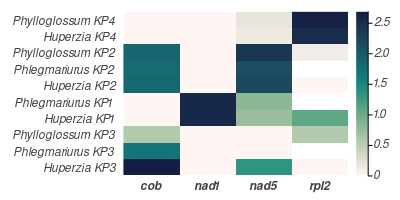

In [22]:
scores = Matrix(target_table[:, 2:5])
scores = max.(scores, 0.0)
@df target_table heatmap(names(target_table)[2:5], reverse(kpnames), scores, cmap = :tempo, xtickfontfamily = "Helvetica Bold Oblique", ytickfontfamily = "Helvetica Oblique", grid = false, fg_border = :white, fg_axis = :white, size=(400,200))

In [ ]:
savefig("target heatmap.svg")